# 1. Nutrient cycle + CFT + Rittmann Detachment

In [1]:
import numpy as np
import pandas as pd
import os, subprocess
from scipy.integrate import odeint
from scipy.optimize import fsolve,root
import matplotlib.pyplot as plt

from cftAttachment.cft import CFT

In [2]:
REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

In [3]:
perm_0, n0 = 1.00E-11 , 0.358 #m2
perm_c, nc = 1.00E-14 , 0.100  #m2
rhoX = 1050. * 1000.   #mgVSS/L(?)
XMAX = (n0 - nc) * rhoX #mgVSS/L

boolClog = True

def getPerm(n):
    return ((perm_0 - perm_c) * np.power((n-nc)/(n0-nc),3) * np.greater(n - nc,0)) + perm_c;

In [4]:
rho, g, mu = 999.79, 9.81, 0.0008891  #kg/m³, m/s², kg/m.s
head, Lenght, Area = 10., 10., 10.*10. #m,m,m²

def getFlow(n):
    if boolClog: perm = getPerm(n)
    else: perm = getPerm(n0)
    
    hydCond = perm * rho * g / mu              # m/s
    velFlow = hydCond * head / Lenght          # m/s
    flowRate = velFlow * Area                  # m³/s
    Volume = Area * Lenght                     # m³
    flow = flowRate/Volume                     # 1/s
    
    #print(f"{perm=}, {hydCond=}, {velFlow=}, {flowRate=}, {Volume=}")
    return flow*86400     # 1/d

q0 = getFlow(n0)*Lenght/86400
print(f"Init Flowrate: {q0*86400:.3f} m/d")
print(f"Init Flowrate: {q0:.3e} m/s")

Init Flowrate: 9.531 m/d
Init Flowrate: 1.103e-04 m/s


In [11]:
# Attachment/detachment kinetics
cftCalc = CFT(q0,n0,alpha=0.01,debug=True)
katt = cftCalc.katt * 86400  #1/d
kdet = 0.02 #1/d

Diffusion coeff:  4.6628E-14
Darcy velocity:   1.1031E-04
Pore-water vel:   3.0814E-04
---
Happel parameter: 4.9758E+01
NR number:        5.0000E-03
NPe number:       1.3217E+07
NvW number:       1.2797E+00
NGr number:       3.3003E+02
---
etaD collector:   1.1122E-04
etaI collector:   9.8600E-04
etaG collector:   4.7853E-03
eta0 collector:   5.8825E-03
---
Attach rate   :   8.7278E-06


In [12]:
khyd_labil = 0.17
khyd_recal = 0.017

In [13]:
print(f"Init attachment rate: {katt/86400:.3e} 1/s")

Init attachment rate: 8.728e-06 1/s


In [14]:
class Kinetics():   
    def __init__(self,Y,qhat,b,fd,kEPS,Kdonor,Kacceptor=0):
        self.Y = Y  #mgVSS/mgBOD 
        self.qhat = qhat  #mgBOD/mgVSS·d
        self.bDie = b  #1/d
        self.fd = fd
        self.kEPS = kEPS
        self.Kdonor = Kdonor    #mgBOD/L
        self.Kaccep = Kacceptor  #mgO2/L
        
    def __repr__(self):
        text = ""
        for attribute, value in self.__dict__.items():
            text += f"{attribute:>6} = {value:>6.3f}\n"
        return text

In [15]:
## Use Y as Y' (Table 8.2 Rittmann 2ndEd)
# Heterotrophs kinetics
pXAR = Kinetics(Y=0.49,qhat=7,b=0.3,fd=0.8,kEPS=0.18,Kdonor=10.,Kacceptor=0.5)

# Autotrophs kinetics
pXN = Kinetics(Y=0.11,qhat=5.6,b=0.1,fd=0.8,kEPS=0.18,Kdonor=0.5,Kacceptor=0.5)

# Denitrifiers kinetics
pXDN = Kinetics(Y=0.20,qhat=12,b=0.05,fd=0.8,kEPS=0.18,Kdonor=1.0,Kacceptor=0.5)

In [16]:
# Mass inputs
DOC_0   = 50.    #mgBOD/L
NH4_0   = 1.    #mgN/L
NO3_0 = 0.5   #mgN/L
O2_0  = 9.    #mgO2/L

XAR_0 = 1.
XN_0  = 1.
XDN_0 = 1.
EPS_0 = 0. 
XI_0 = 0.

BAP_0 = 0.    #mgBOD/L
POCr_0 = 0.   #mgCOD/L
XARp_0 = 0.
XNp_0  = 0.
XDNp_0 = 0.

# Conversions 
gamma_N = 0.124 #mgN/mgVSS
K_I   = 0.6  #mgO2/L
K_minN = 0.1 #mgNH4/L

alpha_1  = 1.00 * (1. - 1.42*pXAR.Y - pXAR.kEPS) #gO2/gBOD
alpha_N  = 4.57 * (1. - 0.31*pXN.Y  -  pXN.kEPS) #gO2/gNH4
beta_1   = 0.35 * (1. - 1.42*pXDN.Y - pXDN.kEPS) #gNO3/gBOD

## 14.1 Numerical solution.

In [31]:
def CSRT(vec, t):

    XAR, XN, XDN, XARp, XNp, XDNp, EPS, XI, BAP, POCr, DOC, NH4, NO3, O2 = vec

    totalBiomass = XAR + XN + XDN + XI + EPS
    n = n0 - totalBiomass/rhoX
    clogLimiter = 1.0 - totalBiomass/XMAX

    # Rates of substrate (electron donor) consumption
    rH = \
        pXAR.qhat  \
        * DOC/(pXAR.Kdonor + DOC)   \
        * O2/(pXAR.Kaccep + O2)     \
        * NH4/(K_minN + NH4)        \
        * clogLimiter

    rN = \
        pXN.qhat \
        * NH4/(pXN.Kdonor + NH4)    \
        * O2/(pXN.Kaccep + O2)      \
        * clogLimiter

    rDN = \
        pXDN.qhat \
        * DOC/(pXDN.Kdonor + DOC)   \
        * NO3/(pXDN.Kaccep + NO3)   \
        * K_I / (K_I + O2)          \
        * clogLimiter

    # Calculate flow
    flow = getFlow(n)

    # Calculate attachment rate
    cftCalc.n = n
    cftCalc.q = flow*Lenght/86400
    katt = cftCalc.katt * 86400

    # Calculate detachment rate

    # Transport equations
    dXAR = pXAR.Y * rH * XAR        \
        - pXAR.bDie * XAR       \
        - kdet * XAR            \
        + n * katt * clogLimiter * XARp

    dXARp = flow*(XARp_0 - XARp)   \
        + pXAR.Y * rH * XARp     \
        - pXAR.bDie * XARp       \
        + kdet * XAR/n           \
        - katt * clogLimiter * XARp

    dXN = pXN.Y * rN * XN           \
        - pXN.bDie * XN         \
        - kdet * XN             \
        + n * katt * clogLimiter * XNp

    dXNp = flow*(XNp_0 - XNp)    \
        + pXN.Y * rN * XNp      \
        - pXN.bDie * XNp        \
        + kdet * XN / n         \
        - katt * clogLimiter * XNp

    dXDN = pXDN.Y * rDN * XDN      \
        - pXDN.bDie * XDN       \
        - kdet * XDN            \
        + n * katt * clogLimiter * XDNp

    dXDNp = flow*(XDNp_0 - XDNp)  \
        + pXDN.Y * rDN * XDNp   \
        - pXDN.bDie * XDNp      \
        + kdet * XDN / n         \
        - katt * clogLimiter * XDNp

    dEPS = (pXAR.kEPS*rH + pXAR.fd*pXAR.bDie) * XAR     \
        + (pXN.kEPS*rN + pXN.fd*pXN.bDie) * XN          \
        + (pXDN.kEPS*rDN + pXDN.fd*pXDN.bDie) * XDN     \
        - kdet * EPS                                    \
        + n * katt * clogLimiter * BAP                  \
        - khyd_labil * EPS

    dXI = (1 - pXAR.fd) * (pXAR.bDie*XAR)          \
        + (1 - pXN.fd) * (pXN.bDie*XN)              \
        + (1 - pXDN.fd) * (pXDN.bDie*XDN)          \
        - kdet * XI                                     \
        + n * katt * clogLimiter * POCr                 \
        - khyd_recal * XI                               

    dDOC = flow*(DOC_0 - DOC)    \
        - rH * XAR /n            \
        - rDN * XDN /n           \
        + khyd_labil * BAP       \
        + khyd_recal * POCr      \
        + khyd_labil * EPS       \
        + khyd_recal * XI        

    dO2 = flow*(O2_0 - O2)      \
        - alpha_1 * rH * (XAR/n + XARp)  \
        - alpha_N * rN * (XN/n  + XNp)

    dNH4 = flow*(NH4_0 - NH4)   \
        - rN * XN/n             \
        + gamma_N * (
            pXAR.fd * pXAR.bDie * XAR          \
            + pXN.fd * pXN.bDie * XN           \
            + pXDN.fd * pXDN.bDie * XDN)/n     \
        + gamma_N * (
            + pXAR.fd * pXAR.bDie * XARp       \
            + pXN.fd * pXN.bDie * XNp          \
            + pXDN.fd * pXDN.bDie * XDNp)      \
        - gamma_N * pXAR.Y * rH * XAR/n     \
        - gamma_N * pXAR.Y * rH * XARp

    dNO3 = flow*(NO3_0 - NO3)                    \
        + (1.0 - 0.31*pXN.Y - pXN.kEPS) * rN * XN  \
        - beta_1 * rDN * (XDN + n*XDNp)

    dBAP = flow*(BAP_0 - BAP)                   \
        + kdet * EPS/n                          \
        - katt * clogLimiter * BAP              \
        - khyd_labil * BAP                      \
        + pXAR.fd * pXAR.bDie * XARp            \
        + pXN.fd * pXN.bDie  * XNp              \
        + pXDN.fd * pXDN.bDie * XDNp          

    dPOCr = flow*(POCr_0 - POCr)               \
        + kdet * XI / n                        \
        - katt * clogLimiter * POCr            \
        - khyd_recal * POCr                    \
        + (1 - pXAR.fd) * pXAR.bDie * XARp     \
        + (1 - pXN.fd) * pXN.bDie  * XNp       \
        + (1 - pXDN.fd) * pXDN.bDie * XDNp

    return [dXAR, dXN, dXDN, dXARp, dXNp, dXDNp, 
        dEPS, dXI, dBAP, dPOCr, dDOC, dNH4, dNO3, dO2]


In [32]:
time = np.linspace(0.0001,30,500)
names = ["XAR", "XN", "XDN", "XARp", "XNp", "XDNp", 
    "EPS", "XI", "BAP", "POCr", "DOC", "NH4", "NO3", "O2"]
init =  [XAR_0, XN_0, XDN_0, XARp_0, XNp_0, XDNp_0, 
    EPS_0, XI_0, BAP_0, POCr_0, DOC_0, NH4_0, NO3_0, O2_0]
tray = odeint(CSRT,init,time)

In [33]:
tray_df = pd.DataFrame({k:v for k,v,i in zip(names,tray.T,init)})
tray_df['Time'] = time
tray_df.set_index('Time',inplace=True)

In [34]:
tray_df

,XAR,XN,XDN,XARp,XNp,XDNp,EPS,XI,BAP,POCr,DOC,NH4,NO3,O2
Time,,,,,,,,,,,,,,
0.00010,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,1.000000,0.500000,9.000000
0.06022,1.129242,1.013115,1.001121,0.003607,0.003236,0.003197,0.115022,0.005647,0.000224,0.000018,49.099055,0.455646,0.636264,7.094579
0.12034,1.242394,1.018114,1.003901,0.007553,0.006190,0.006103,0.213794,0.011741,0.000841,0.000071,48.304582,0.147040,0.707143,6.022921
0.18046,1.308380,1.015927,1.007635,0.011365,0.008825,0.008752,0.285236,0.018154,0.001734,0.000158,47.795200,0.049191,0.723210,5.681397
0.24058,1.339979,1.011208,1.011658,0.014794,0.011165,0.011169,0.340297,0.024717,0.002793,0.000273,47.496288,0.031994,0.720208,5.611141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29.75952,25.916860,0.107508,4.562220,0.854464,0.003544,0.150414,48.711586,20.898217,1.545804,0.689002,3.449820,0.083392,0.140985,2.049684
29.81964,25.932962,0.107248,4.570863,0.854996,0.003536,0.150699,48.773131,20.959247,1.547811,0.691015,3.438794,0.083760,0.140688,2.046369
29.87976,25.948925,0.106991,4.579495,0.855523,0.003527,0.150984,48.834337,21.020237,1.549807,0.693027,3.427917,0.084127,0.140392,2.043084


In [35]:
tray_df["totalBiomass"] = tray_df[['XAR','XN','XDN','XI','EPS']].sum(axis=1)
names.append("totalBiomass")

tray_df["Q"] = getFlow(n0 - tray_df["totalBiomass"]/rhoX)
names.append("Q")

In [36]:
# cftCalcPost = CFT(q0,n0,alpha=0.01,debug=False)
# tray_df["katt"] = [ (CFT(qvar,nvar,alpha=0.01)).katt for qvar,nvar in zip(tray_df['Q']/86400,n0 - tray_df['X']/rhoX)]

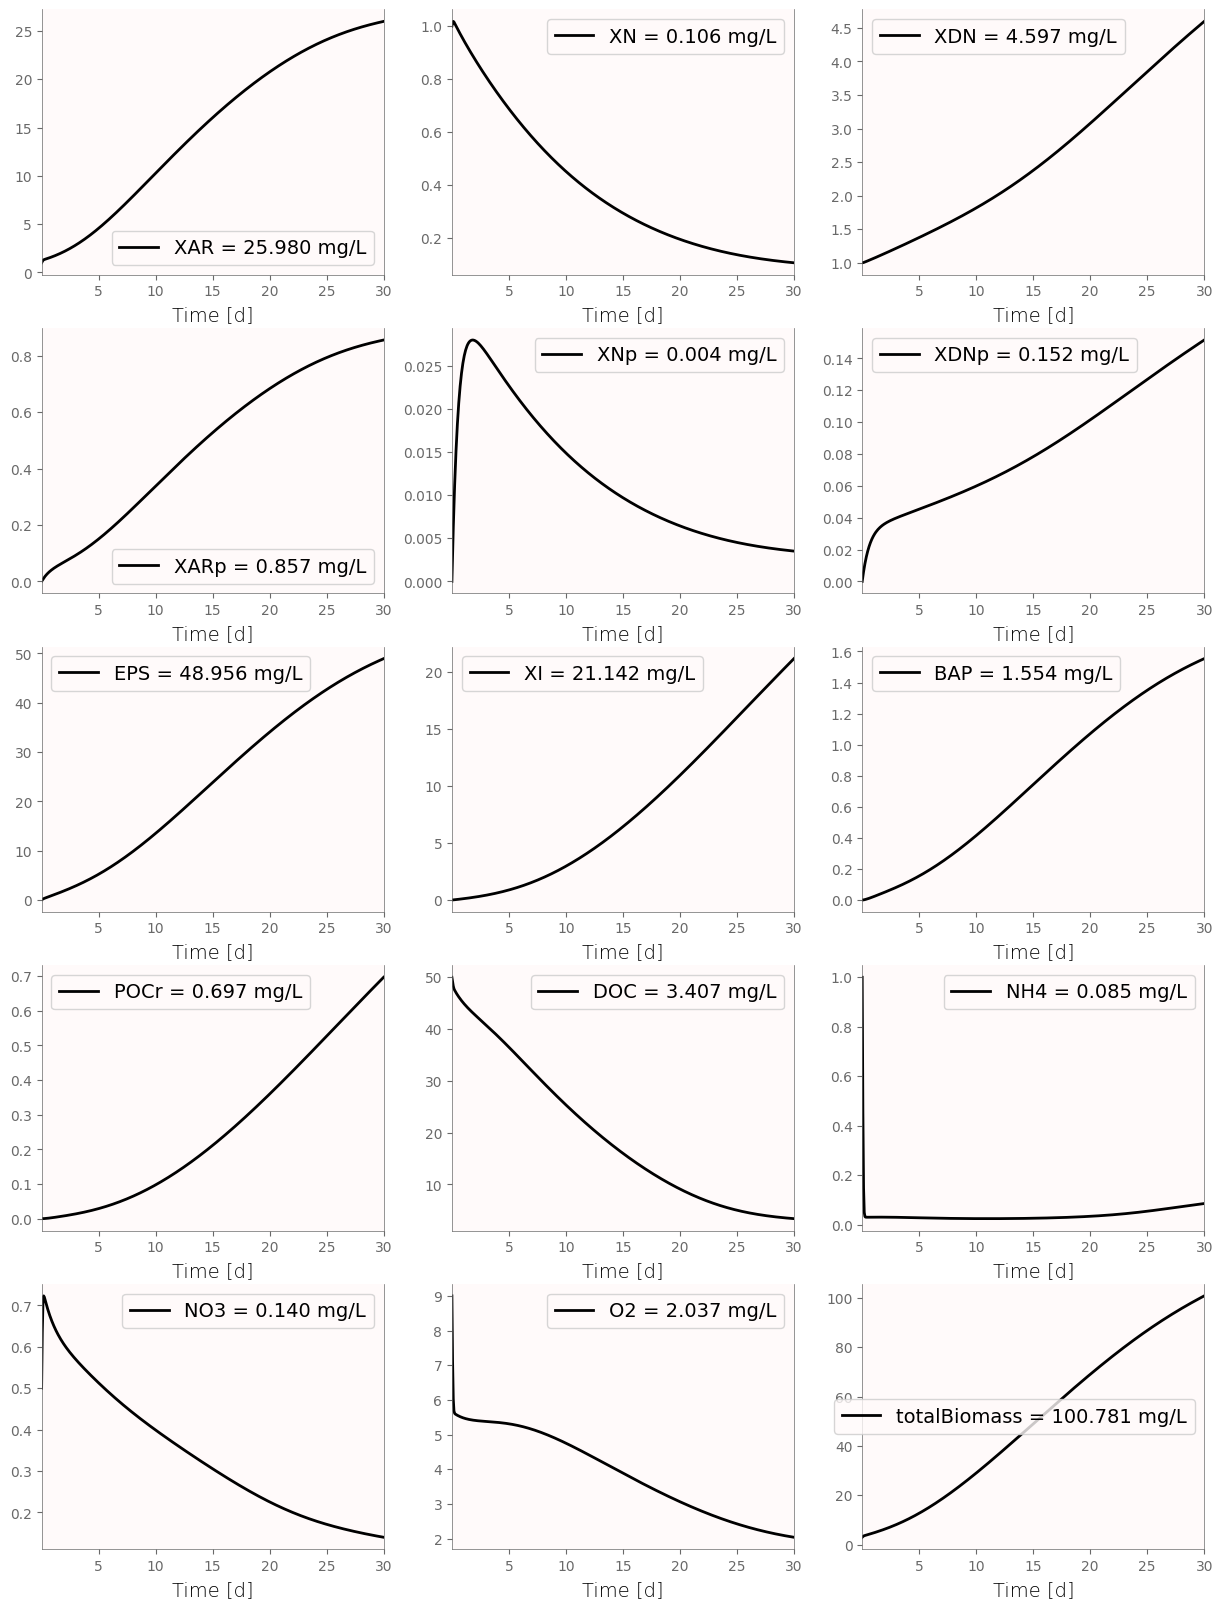

In [37]:
fig,axs = plt.subplots(5,3,figsize=[15,20])
for (name,data),ax in zip(tray_df.iteritems(),axs.flatten()):
    ax.plot(time,data,label='{0} = {1:.3f} mg/L'.format(name,data.iloc[-1]))
    ax.set(xlim=[0.01,30],xlabel="Time [d]")
    #ax.set_ylim(bottom=0)
    ax.legend()
[ax.remove() for ax in axs.flatten() if not ax.has_data()]
plt.show()

### 14.2 OpenFOAM implementation 

Using `cloggingFoam`

In [ ]:
caseName   = "AllOn"
solverFoam = "nutrientCycle"
probeVars  = " ".join(["XAR", "XN", "XDN", "XARp", "XNp", "XDNp", 
    "EPS", "XI", "BAP", "POCr", "DOC", "NH4", "NO3", "O2"])

## Check that solver is compiled
if not(solverFoam in subprocess.run(["which",f"{solverFoam}"],capture_output=True).stdout.decode('utf-8').strip()):
    print("######### SOLVER NOT FOUND ############")

In [ ]:
## Run case
os.system(f"cp {REPO_PATH}/misc/probes.tpl {caseName}/system/probes; sed -i 's/<<LIST_OF_VARIABLES_TO_MEASURE>>/({probeVars})/g' {caseName}/system/probes")
os.system(f"cd {caseName}; ./runAll.sh {solverFoam}");

In [ ]:
path_case = f"{REPO_PATH}/tests/{solverFoam}/{caseName}/postProcessing/probes/0.000"
probes = os.listdir(path_case)
probes.sort(reverse=True)

In [ ]:
results = pd.DataFrame()
for i,probe in enumerate(probes):
    if i == 0:
        results = pd.read_fwf(os.path.join(path_case,probe),
                              widths=[13,14],skiprows=3,
                              names=["Time (s)",str(probe)])
        results.set_index("Time (s)",inplace=True)
    else:
        if probe == "U":
            results = results.join(pd.read_fwf(os.path.join(path_case,probe),
                                               widths=[13,33],skiprows=3,
                                               names=["Time (s)",str(probe)]).set_index("Time (s)"),
                                   on='Time (s)')
            results['U'] = [float(v.split(" ")[-1].replace(")","")) for v in results['U']]
            results['U'] = results['U']*10*10*-86400/(1000*1000)
        
        else:
            results = results.join(pd.read_fwf(os.path.join(path_case,probe),
                                               widths=[13,14],skiprows=3,
                                               names=["Time (s)",str(probe)]).set_index("Time (s)"),
                                   on='Time (s)')

In [ ]:
fig,axs = plt.subplots(4,3,figsize=[15,15],sharex=False)
texts = ['suspendedClay', 'depositedClay', 'U',]
for (name,data),ax,k in zip(tray_df.iteritems(),axs.flatten(),texts):
    ax.plot(time,data,label='Py: {0} = {1:.3f} mg/L'.format(name,data.iloc[-1]),lw=5,alpha=0.99,c='orange')
    ax.plot(results.index/86400.,results[k]*1000.,label='OF: {0} = {1:.3f} mg/L'.format(k,results[k].iloc[-1]*1000.))
    ax.set(xlim=[0.01,30],xlabel="Time [d]")
    #ax.set_ylim(bottom=0)
    ax.legend(loc="upper center",bbox_to_anchor=(0.5,-0.3))
[ax.remove() for ax in axs.flatten() if not ax.has_data()]
plt.show()


In [ ]:
fig,ax = plt.subplots()
ax.plot(time,tray_df['katt'],label="Python")
ax.plot(results.index/86400.,results['katt'],label='OF')
ax.legend()
plt.show()

In [ ]:
ix = 0
print(f"Python   : {tray_df['katt'].iloc[ix]:.3E}") 
print(f"OpenFOAM : {results['katt'].iloc[ix]:.3E}")

In [ ]:
# Clean timesteps
os.system(f"cd {caseName}; foamListTimes -rm; rm -r dynamicCode VTK log")